In [58]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from models import BasicRNN, RNN_New
from dataset import NormalizedProfilesDataset
from utils import load_normalization_metadata
import time

plt.style.use('science')

In [59]:
# Paths
model_params_path = "Data/Model/model_parameters.json"
model_save_path = "Data/Model/best_model.pth"
data_folder = "Data/Normalized_Profiles"
save_path = "Figures"

# Load the model parameters
with open(model_params_path, 'r') as f:
    model_params = json.load(f)

# Display the model parameters
print("Loaded model parameters:")
print(json.dumps(model_params, indent=4))

Loaded model parameters:
{
    "model_type": "BasicRNN",
    "RNN_type": "LSTM",
    "nx": 4,
    "ny": 1,
    "nx_sfc": 0,
    "nneur": [
        32,
        32
    ],
    "outputs_one_longer": false,
    "concat": false,
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 500,
    "input_variables": [
        "pressure",
        "temperature",
        "Tstar",
        "flux_surface_down"
    ],
    "target_variables": [
        "net_flux"
    ]
}


In [60]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retrieve model_type
model_type = model_params.get("model_type", "RNN_New")

# Initialize the model dynamically based on model_type
if model_type == 'BasicRNN':
    model = BasicRNN(
        RNN_type=model_params['RNN_type'],
        nx=model_params['nx'],
        ny=model_params['ny'],
        nneur=tuple(model_params['nneur']),
        outputs_one_longer=model_params['outputs_one_longer'],
        concat=model_params['concat']
    )
elif model_type == 'RNN_New':
    model = RNN_New(
        RNN_type=model_params['RNN_type'],
        nx=model_params['nx'],
        ny=model_params['ny'],
        nneur=tuple(model_params['nneur']),
        outputs_one_longer=model_params['outputs_one_longer'],
        concat=model_params['concat']
    )
else:
    raise ValueError(f"Unknown model type: {model_type}")

# Load the trained model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.to(device)
model.eval()

print(f"Model '{model_type}' loaded and ready for evaluation.")


Model 'BasicRNN' loaded and ready for evaluation.


/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_48309/1995295661.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_

In [61]:
# Load normalization metadata
normalization_metadata = load_normalization_metadata()

# Expected length of profiles
expected_length = 50

# Initialize the test dataset
test_dataset = NormalizedProfilesDataset(
    data_folder,
    expected_length=50,
    input_variables=['pressure', 'temperature', 'Tstar', 'flux_surface_down'],
    target_variables=['net_flux']
)

# Create DataLoader
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)

print("Test dataset loaded.")


Test dataset loaded.


In [62]:
print(test_dataset)

In [63]:
def denormalize(norm_values, metadata, variable_name, method):
    """
    Denormalize a given variable based on the provided normalization method and metadata.

    Parameters:
        norm_values (array or tensor): Normalized values.
        metadata (dict): Dictionary containing normalization metadata.
        variable_name (str): Name of the variable to denormalize (e.g. 'pressure', 'net_flux').
        method (str): Normalization method used ('min-max', 'standard', etc.).

    Returns:
        Denormalized values. For pressure, returns values in Bar.
    """
    if method == "min-max":
        # For min-max, assume stored values in metadata are in log-scale for pressure.
        min_val = metadata[variable_name]["min"]
        max_val = metadata[variable_name]["max"]
        denorm = norm_values * (max_val - min_val) + min_val

        # Convert log-pressure to pressure (if this is pressure)
        if variable_name == 'pressure':
            denorm = 10 ** denorm
        return denorm

    elif method == "standard":
        # For standardization, assume mean and std in metadata
        mean_val = metadata[variable_name]["mean"]
        std_val = metadata[variable_name]["std"]
        denorm = norm_values * std_val + mean_val

        # Convert log-pressure to pressure if this is pressure
        if variable_name == 'pressure':
            denorm = 10 ** denorm
        return denorm

    else:
        raise ValueError(f"Unsupported normalization method: {method}")


In [64]:
print(test_loader)

Prediction time for profile 1: 1.23e-03 seconds
Prediction time for profile 2: 1.14e-03 seconds
Prediction time for profile 3: 1.05e-03 seconds
Prediction time for profile 4: 9.38e-04 seconds
Prediction time for profile 5: 9.30e-04 seconds
Prediction time for profile 6: 9.16e-04 seconds
Prediction time for profile 7: 8.69e-04 seconds
Prediction time for profile 8: 8.62e-04 seconds
Prediction time for profile 9: 8.66e-04 seconds
Prediction time for profile 10: 8.67e-04 seconds


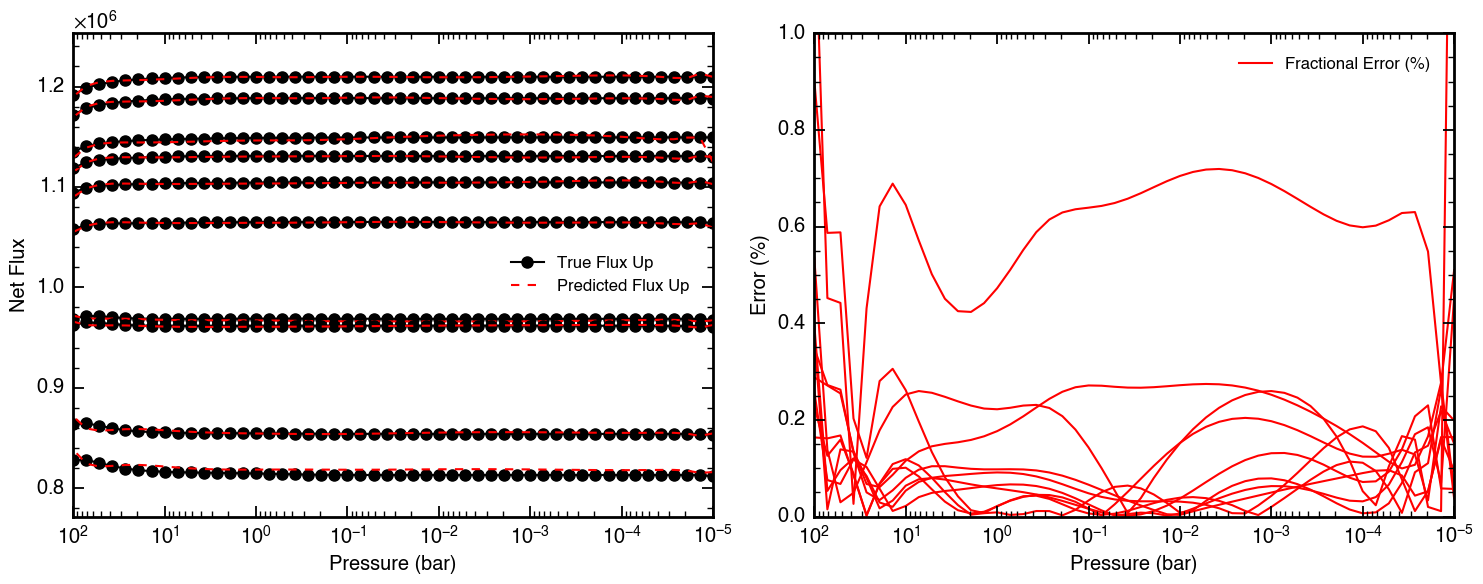

In [67]:
import time
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# Number of profiles to visualize
N = 10

# Create a directory for saving plots if it doesn't exist
os.makedirs(save_path, exist_ok=True)

with torch.no_grad():
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Two subplots side-by-side

    for idx, data in enumerate(test_loader):
        # Stop after plotting N samples
        if idx == N:
            break

        # Unpack data, ignoring extra elements if necessary
        if model_type == 'RNN_New':
            inputs, targets = data
        elif model_type == 'BasicRNN':
            inputs, targets, *_ = data  # Ignore any extra elements
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        # Move data to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Verify input feature size matches model expectation
        expected_nx = model_params['nx']
        actual_nx = inputs.size(-1)
        if actual_nx != expected_nx:
            raise ValueError(f"Input feature size mismatch: Model expects nx={expected_nx}, got nx={actual_nx}.")

        # Time the prediction step
        start_time = time.time()
        outputs = model(inputs_main=inputs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Prediction time for profile {idx + 1}: {elapsed_time:.2e} seconds")

        # Move tensors to CPU and convert to numpy
        inputs_np = inputs.cpu().numpy()
        targets_np = targets.cpu().numpy()
        outputs_np = outputs.cpu().numpy()

        # Denormalize pressure (assuming pressure is the first input feature)
        pressure_norm = inputs_np[:, :, 0]
        pressure_method = normalization_metadata["normalization_methods"]["pressure"]
        pressure = denormalize(pressure_norm, normalization_metadata, "pressure", pressure_method)

        # Extract flux_up from targets and outputs (assuming flux_up is index 0)
        net_flux_true_norm = targets_np[:, :, 0]  # shape: (batch, seq_len)
        net_flux_pred_norm = outputs_np[:, :, 0]  # shape: (batch, seq_len)

        # Denormalize flux_up
        net_flux_method = normalization_metadata["normalization_methods"]["net_flux"]
        net_flux_true = denormalize(net_flux_true_norm, normalization_metadata, "net_flux", net_flux_method)
        net_flux_pred = denormalize(net_flux_pred_norm, normalization_metadata, "net_flux", net_flux_method)

        # Calculate fractional error
        fractional_error = np.abs(net_flux_pred - net_flux_true) / (np.abs(net_flux_true) + 1e-8)

        # Plot results
        # Assuming batch_size=1 for simplicity; if >1, you may need to select which sample to plot
        if idx == 0:
            axes[0].plot(pressure[0], net_flux_true[0], label='True Flux Up', marker='o', color='black')
            axes[0].plot(pressure[0], net_flux_pred[0], label='Predicted Flux Up', linestyle='--', color='red')
            axes[1].plot(pressure[0], fractional_error[0] * 100, label='Fractional Error (%)', color='red')
        else:
            axes[0].plot(pressure[0], net_flux_true[0], marker='o', color='black')
            axes[0].plot(pressure[0], net_flux_pred[0], linestyle='--', color='red')
            axes[1].plot(pressure[0], fractional_error[0] * 100, color='red')

    # Configure the left subplot (True vs Predicted Flux Up)
    axes[0].set_xscale('log')
    axes[0].invert_xaxis()
    axes[0].set_xlabel('Pressure (bar)')
    axes[0].set_ylabel('Net Flux')
    axes[0].legend(loc='best')

    # Configure the right subplot (Fractional Error)
    axes[1].set_ylim(0, 1)  # Adjust as needed
    axes[1].set_xscale('log')
    axes[1].invert_xaxis()
    axes[1].set_xlabel('Pressure (bar)')
    axes[1].set_ylabel('Error (%)')
    axes[1].legend(loc='best')

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "flux_up_comparison.png"))
    plt.show()
